# Training Neural Networks

## So far......
## -Loding data, normalising data, 
## Loading train and test data,
## building the NN network using three different ways, 
## nn.sequential preferred, 
## initializing weigts and viewing the weights, 



The network we built in the previous part isn't so smart, it doesn't know anything about our handwritten digits. Neural networks with non-linear activations work like universal function approximators. There is some function that maps your input to the output. For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.

<img src="TD_images/function_approx.png" width=500px>

At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

To find these parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a **loss function** (also called the cost), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems

$$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. **gradient descent** is used to find the minimum

## Backpropagation



Training multilayer networks is done through **backpropagation** 
--> application of the chain rule from calculus. 

<img src='TD_images/backprop_diagram.png' width=550px>

In the forward pass through the network, our data and operations go from bottom to top here. 

We pass the input $x$ through a linear transformation $L_1$ with weights $W_1$ and biases $b_1$.

The output then goes through the sigmoid operation $S$ and another linear transformation $L_2$. Finally we calculate the loss $\ell$. 
We use the loss as a measure of how bad the network's predictions are. The goal then is to adjust the weights and biases to minimize the loss.

To train the weights with gradient descent, we propagate the gradient of the loss backwards through the network. Each operation has some gradient between the inputs and outputs. As we send the gradients backwards, we multiply the incoming gradient with the gradient for the operation. Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.

$$
\large \frac{\partial \ell}{\partial W_1} = \frac{\partial L_1}{\partial W_1} \frac{\partial S}{\partial L_1} \frac{\partial L_2}{\partial S} \frac{\partial \ell}{\partial L_2}
$$


We update our weights using this gradient with some learning rate $\alpha$. 

$$
\large W^\prime_1 = W_1 - \alpha \frac{\partial \ell}{\partial W_1}
$$

The learning rate $\alpha$ is set such that the weight update steps are small enough that the iterative method settles in a minimum.

## Losses in PyTorch

Recall from lecture: 
<img src='TD_images/loss1.png'>



Let's start by seeing how we calculate the loss with PyTorch. 

Through the `nn` module, 
PyTorch provides losses such as the **cross-entropy loss (`nn.CrossEntropyLoss`)**.

**You'll usually see the loss assigned to `criterion`.** 

As noted in the last part, with a classification problem such as MNIST, we're using the softmax function to predict class probabilities. 
**With a softmax output, you want to use cross-entropy as the loss**. 
To actually calculate the loss, you first define the criterion then **pass in the output of your network and the correct labels**

**Very Important**
Looking at [the documentation for `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss),

> This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
>
> The input is expected to contain scores for each class.

**This means we need to pass in the raw output of our network into the loss, not the output of the softmax function**. 

# **This raw output is usually called the *logits* or *scores* **.

We use the logits because softmax gives you probabilities which will often be very close to zero or one. ...... 

but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)).

**It's usually best to avoid doing calculations with probabilities, typically we use log-probabilities.**

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [2]:
# Build a feed-forward network
mymodel = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = mymodel(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3067, grad_fn=<NllLossBackward0>)


According to best practices, 
it's more convenient to build the model with a log-softmax output using `nn.LogSoftmax` or `F.log_softmax` 

([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.LogSoftmax)). 

Then you can get the actual probabilites by taking the exponential `torch.exp(output)`. 

**With a log-softmax output, you want to use the negative log likelihood loss, `nn.NLLLoss`** ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss)).

**Compared to previous cell, here logits are not given out but log-softmax outputs are given out + NLLs loss applied** (preferrred based on experience

>**Exercise:** Build a model that returns the log-softmax as the output and calculate the loss using the negative log likelihood loss.

In [7]:
## Solution

# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))## see the difference

# Define the loss
criterion = nn.NLLLoss()

# Get our data
images, labels = next(iter(trainloader))

# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our log-probabilities
logits = mymodel(images)

# Calculate the loss with the logps and the labels
loss = criterion(logits, labels)

print(loss)

tensor(0.0221, grad_fn=<NllLossBackward0>)


To calculate the gradients, you need to run the `.backward` method on a Variable, `z` for example. This will calculate the gradient for `z` with respect to `x`

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

These gradients calculations are particularly useful for neural networks. For training we need the gradients of the weights with respect to the cost. With PyTorch, we run data forward through the network to calculate the loss, then, go backwards to calculate the gradients with respect to the loss. Once we have the gradients we can make a gradient descent step. 

## Loss and Autograd together

When we create a network with PyTorch, all of the parameters are initialized with `requires_grad = True`. This means that when we calculate the loss and call `loss.backward()`, the gradients for the parameters are calculated. These gradients are used to update the weights with gradient descent. Below you can see an example of calculating the gradients using a backwards pass.

In [8]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 None


## Training the network!

**Before training, we need an optimizer that we'll use to update the weights with the gradients**

We get these from PyTorch's [`optim` package](https://pytorch.org/docs/stable/optim.html). 

For example we can use stochastic gradient descent with `optim.SGD`. You can see how to define an optimizer below.

In [10]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

Now we know how to use all the individual parts so it's time to see how they work together. Let's consider just one learning step before looping through all the data. 

The general process with PyTorch: 
# one learning step
 
# * Make a forward pass through the network 
# * Use the network output to calculate the loss
# * Perform a backward pass through the network with `loss.backward()` to calculate the gradients
# * Take a step with the optimizer to update the weights

But first, 
## Lets go through one training step and print out the weights and gradients so you can see how it changes.


Note that I have a line of code `optimizer.zero_grad()`. 
**When you do multiple backwards passes with the same parameters, the gradients are accumulated.
**This means that you need to zero the gradients on each training pass or you'll retain gradients from previous training batches.

In [11]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images) #forward pass
loss = criterion(output, labels) # loss calculate
loss.backward() #backward
print('Gradient -', model[0].weight.grad)#get the weigts

Initial weights -  Parameter containing:
tensor([[ 0.0043,  0.0181, -0.0159,  ..., -0.0136,  0.0160, -0.0167],
        [-0.0351, -0.0123, -0.0344,  ..., -0.0055,  0.0111, -0.0282],
        [ 0.0355, -0.0184,  0.0087,  ..., -0.0305,  0.0033, -0.0007],
        ...,
        [-0.0234, -0.0111,  0.0099,  ..., -0.0246, -0.0283,  0.0212],
        [ 0.0329,  0.0236,  0.0039,  ...,  0.0064, -0.0022, -0.0250],
        [-0.0180,  0.0243, -0.0207,  ..., -0.0072, -0.0109,  0.0043]],
       requires_grad=True)
Gradient - tensor([[ 2.2584e-03,  2.2584e-03,  2.2584e-03,  ...,  2.2584e-03,
          2.2584e-03,  2.2584e-03],
        [ 1.1457e-04,  1.1457e-04,  1.1457e-04,  ...,  1.1457e-04,
          1.1457e-04,  1.1457e-04],
        [ 2.4850e-03,  2.4850e-03,  2.4850e-03,  ...,  2.4850e-03,
          2.4850e-03,  2.4850e-03],
        ...,
        [-5.4069e-03, -5.4069e-03, -5.4069e-03,  ..., -5.4069e-03,
         -5.4069e-03, -5.4069e-03],
        [-2.5945e-03, -2.5945e-03, -2.5945e-03,  ..., -2.5945e

In [11]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[ 0.0089,  0.0191,  0.0166,  ...,  0.0186,  0.0319,  0.0164],
        [ 0.0100,  0.0213,  0.0292,  ...,  0.0216, -0.0088,  0.0298],
        [ 0.0264, -0.0142, -0.0130,  ..., -0.0286, -0.0042,  0.0120],
        ...,
        [-0.0087, -0.0065,  0.0113,  ...,  0.0319, -0.0140, -0.0231],
        [ 0.0090, -0.0166,  0.0138,  ...,  0.0243,  0.0330, -0.0041],
        [-0.0073,  0.0286,  0.0190,  ..., -0.0083,  0.0157, -0.0271]],
       requires_grad=True)


### Training for real

Now we'll put this algorithm into a loop so we can go through all the images. 

Some nomenclature, one pass through the entire dataset is called an *epoch*. 

So here we're going to loop through `trainloader` to get our training batches. 

For each batch, we'll doing a training pass where we calculate the loss, do a backwards pass, and update the weights.

> **Exercise: ** Implement the training pass for our network. If you implemented it correctly, you should see the training loss drop with each epoch.

In [18]:
my1model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(my1model.parameters(), lr=0.01)

epochs = 30
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = mymodel(images)
        loss = criterion(output, labels)
        
        #Backpropagate the loss
        loss.backward()
        
        #take one step of optimiser
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.012126222258244555
Training loss: 0.012107634279409796
Training loss: 0.012132881472367785
Training loss: 0.012102747934209908
Training loss: 0.012124968149616364
Training loss: 0.012091640210926418
Training loss: 0.012115000829367197
Training loss: 0.012110017629412027
Training loss: 0.012106815852424149
Training loss: 0.012126952566495383
Training loss: 0.01210170742613313
Training loss: 0.012101607427543608
Training loss: 0.012113927790065055
Training loss: 0.012144371684737948
Training loss: 0.012125155887691114
Training loss: 0.012103442051227011
Training loss: 0.012109191220344059
Training loss: 0.012131431806740835
Training loss: 0.01210180149660128
Training loss: 0.012135878950953166
Training loss: 0.01211400767300538
Training loss: 0.012133767948577007
Training loss: 0.01210931051706921
Training loss: 0.01212634770990238
Training loss: 0.012104219571103468
Training loss: 0.012112551103115205
Training loss: 0.01211425152413402
Training loss: 0.01210961370277893

With the network trained, we can check out it's predictions.

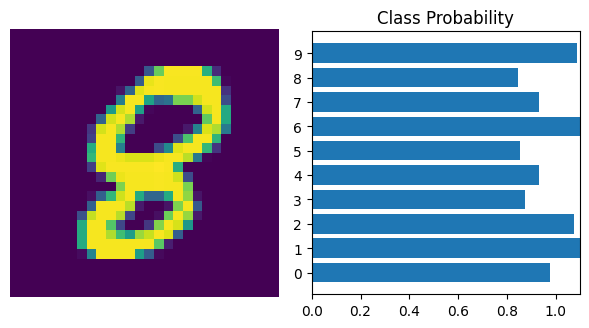

In [17]:
%matplotlib inline
import helper1

images, labels = next(iter(trainloader))

img = images[8].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = mymodel(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper1.view_classify(img.view(1, 28, 28), ps)

Now our network is brilliant. It can accurately predict the digits in our images. Next up you'll write the code for training a neural network on a more complex dataset.